## Tabular data

In [ ]:
from fastai.gen_doc.nbdoc import *
from fastai.tabular.models import *

[`tabular`](/tabular.html#tabular) contains all the necessary classes to deal with tabular data, across two modules:
- [`tabular.transform`](/tabular.transform.html#tabular.transform): defines the [`TabularTransform`](/tabular.transform.html#TabularTransform) class to help with preprocessing;
- [`tabular.data`](/tabular.data.html#tabular.data): defines the [`TabularDataset`](/tabular.data.html#TabularDataset) that handles that data, as well as the methods to quickly get a [`TabularDataBunch`](/tabular.data.html#TabularDataBunch).

To create a model, you'll need to use [`models.tabular`](/tabular.html#tabular). See below for an end-to-end example using all these modules.

## Preprocessing tabular data

First, let's import everything we need for the tabular application.

In [ ]:
from fastai.tabular import * 

Tabular data usually comes in the form of a delimited file (such as .csv) containing variables of different kinds: text/category, numbers, and perhaps some missing values. The example we'll work with in this section is a sample of the [adult dataset](https://archive.ics.uci.edu/ml/datasets/adult) which has some census information on individuals. We'll use it to train a model to predict whether salary is greater than \$50k or not.

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)
path

PosixPath('/Users/njs/.fastai/data/adult_sample')

In [ ]:
df = pd.read_csv(path/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


Here all the information that will form our input is in the 14 first columns, and the dependent variable is the last column. We will split our input between two types of variables: categorical and continuous.
- Categorical variables will be replaced by a category - a unique id that identifies them - before they are passed through an embedding layer.
- Continuous variables will be normalized and then directly fed to the model.

Another thing we need to handle are the missing values: our model isn't going to like receiving NaNs so we should remove them in a smart way. All of this preprocessing is done by [`TabularTransform`](/tabular.transform.html#TabularTransform) objects and [`TabularDataset`](/tabular.data.html#TabularDataset).

We can define a bunch of Transforms that will be applied to our variables. Here we transform all categorical variables into categories. We also replace missing values for continuous variables by the median column value and normalize those.

In [ ]:
procs = [FillMissing, Categorify, Normalize]

To split our data into training and validation sets, we use valid indexes

In [ ]:
valid_idx = range(len(df)-2000, len(df))

Then let's manually split our variables into categorical and continuous variables (we can ignore the dependent variable at this stage). fastai will assume all variables that aren't dependent or categorical are continuous, unless we explicitly pass a list to the `cont_names` parameter when constructing our [`DataBunch`](/basic_data.html#DataBunch).

In [ ]:
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

Now we're ready to pass this information to [`TabularDataBunch.from_df`](/tabular.data.html#TabularDataBunch.from_df) to create the [`DataBunch`](/basic_data.html#DataBunch) that we'll use for training.

In [ ]:
data = TabularDataBunch.from_df(path, df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)
print(data.train_ds.cont_names)  # `cont_names` defaults to: set(df)-set(cat_names)-{dep_var}

['capital-loss', 'hours-per-week', 'age', 'capital-gain', 'fnlwgt', 'education-num']


We can grab a mini-batch of data and take a look (note that [`to_np`](/torch_core.html#to_np) here converts from pytorch tensor to numpy):

In [ ]:
(cat_x,cont_x),y = next(iter(data.train_dl))
for o in (cat_x, cont_x, y): print(to_np(o[:5]))

[[ 5 13  3  5  1  5  2 40  1]
 [ 5 16  3 15  1  5  2 40  1]
 [ 5 10  3  5  1  5  2 40  1]
 [ 5  1  5 15  5  5  2 40  1]
 [ 1 16  5  1  4  5  2 40  1]]
[[-0.145922  0.111224 -0.035789 -0.216787  0.173985  1.537552]
 [-0.145922 -1.01139  -0.035789 -0.216787 -0.70474  -0.029745]
 [-0.145922 -0.152586 -0.035789 -0.216787  0.247212  1.145728]
 [-0.145922  0.38698  -0.035789 -0.216787  0.247212 -1.597042]
 [-0.145922  0.112975 -0.439748 -0.216787 -1.363784 -0.029745]]
[1 0 1 1 0]


After being processed in [`TabularDataset`](/tabular.data.html#TabularDataset), the categorical variables are replaced by ids and the continuous variables are normalized. The codes corresponding to categorical variables are all put together, as are all the continuous variables.

## Defining a model

Once we have our data ready in a [`DataBunch`](/basic_data.html#DataBunch), we just need to create a model to then define a [`Learner`](/basic_train.html#Learner) and start training. The fastai library has a flexible and powerful [`TabularModel`](/tabular.models.html#TabularModel) in [`models.tabular`](/tabular.html#tabular). A convenience function, `tabular_learner`, creates a `TabularModel` for you. We need to specify the number of neurons in each layer, and, if we wish, choose embedding sizes for some or all of our categorical variables. 

In [ ]:
learn = tabular_learner(data, layers=[200,100], emb_szs={'native-country': 10}, metrics=accuracy)

In [ ]:
emb_szs = data.get_emb_szs({'native-country': 10})

In [ ]:
model = TabularModel(emb_szs=emb_szs, n_cont=len(data.cont_names), out_sz=data.c, layers=[58,58,58,58])

In [ ]:
model.get_sizes(out_sz=data.c, layers=[58,58,58,58])

[58, 58, 58, 58, 58, 2]

In [ ]:
#learn = tabular_learner(data, layers=[200,100], emb_szs={'native-country': 10}, metrics=accuracy)
learn = Learner(data, model, metrics=accuracy)
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.345479,0.329604,0.844500,00:04
1,0.333145,0.333795,0.835500,00:04
2,0.339628,0.331258,0.838500,00:04
3,0.326475,0.317530,0.846000,00:04
4,0.332636,0.321952,0.848500,00:04
5,0.333098,0.315263,0.845500,00:05
6,0.328081,0.317572,0.850000,00:05
7,0.316246,0.310698,0.856500,00:05
8,0.317689,0.311790,0.851500,00:05
9,0.305330,0.312516,0.853000,00:05


As usual, we can use the [`Learner.predict`](/basic_train.html#Learner.predict) method to get predictions. In this case, we need to pass the row of a dataframe that has the same names of categorical and continuous variables as our training or validation dataframe.

In [ ]:
model = TabularModel(emb_szs=emb_szs, n_cont=len(data.cont_names), out_sz=data.c, layers=[58,58,58,58,58,58,58,58])
learn = Learner(data, model, metrics=accuracy)
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.349091,0.336107,0.838000,00:06
1,0.340463,0.320935,0.845000,00:06
2,0.333229,0.333565,0.848500,00:06
3,0.338986,0.320656,0.845500,00:07
4,0.335786,0.324878,0.851500,00:07
5,0.326960,0.326785,0.840000,00:07
6,0.328916,0.319750,0.845000,00:07
7,0.316086,0.320181,0.847000,00:07
8,0.313323,0.319059,0.847000,00:07
9,0.311730,0.313029,0.847500,00:07


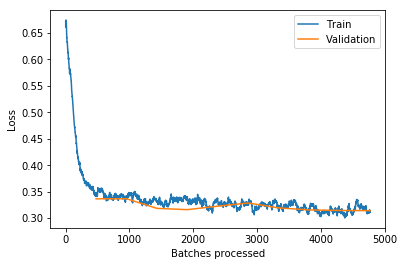

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.predict(df.iloc[0])

(Category >=50k, tensor(1), tensor([0.2022, 0.7978]))

## Now add skip connections

In [ ]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Embedding            [1, 6]               60         True      
______________________________________________________________________
Embedding            [1, 8]               136        True      
______________________________________________________________________
Embedding            [1, 5]               40         True      
______________________________________________________________________
Embedding            [1, 8]               128        True      
______________________________________________________________________
Embedding            [1, 5]               35         True      
______________________________________________________________________
Embedding            [1, 4]               24         True      
______________________________________________________________________
Embedding            [1, 3]               9          True      
______________________________________________________________

In [ ]:
help(TabularResnetModel)

Help on class TabularResnetModel in module fastai.tabular.models:

class TabularResnetModel(torch.nn.modules.module.Module)
 |  TabularResnetModel(emb_szs: Collection[Tuple[int, int]], n_cont: int, out_sz: int, block_sizes: Collection[int], bottle: bool = False, dense: bool = False, emb_drop: float = 0.0, y_range: Union[Tuple[float, float], NoneType] = None, bn: bool = True, p: float = 0.0, bn_final: bool = False)
 |  
 |  Resnet model for tabular data.
 |  
 |  Method resolution order:
 |      TabularResnetModel
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, emb_szs: Collection[Tuple[int, int]], n_cont: int, out_sz: int, block_sizes: Collection[int], bottle: bool = False, dense: bool = False, emb_drop: float = 0.0, y_range: Union[Tuple[float, float], NoneType] = None, bn: bool = True, p: float = 0.0, bn_final: bool = False)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  forward(self

In [ ]:
model = TabularResnetModel(emb_szs=emb_szs, n_cont=len(data.cont_names), out_sz=data.c, block_sizes=[58,58,116,116])

In [ ]:
learn = Learner(data, model, metrics=accuracy)
#learn.fit_one_cycle(10, 1e-2)

In [ ]:
sizes = model.get_sizes(out_sz=data.c, block_sizes=[58,58,116,116])
print(sizes)
for i,(ni,no) in enumerate(zip(sizes[:-1], sizes[1:])):
    print('{}: {} -> {}'.format(i,ni,no))

[58, 58, 58, 116, 116, 2]
0: 58 -> 58
1: 58 -> 58
2: 58 -> 116
3: 116 -> 116
4: 116 -> 2


In [ ]:
len(sizes[:-1])

5

In [ ]:
model = TabularModelSkip(emb_szs=emb_szs, n_cont=len(data.cont_names), out_sz=data.c, layers=[58,58,58,58,58,58,58,58],
                        skip=2, dense=False)
learn = Learner(data, model, metrics=accuracy)
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.348473,0.336424,0.840500,00:06
1,0.339819,0.336572,0.834000,00:06
2,0.330948,0.318375,0.849000,00:06
3,0.338658,0.315989,0.847500,00:06
4,0.334085,0.322630,0.842000,00:06
5,0.325852,0.328565,0.847000,00:07
6,0.313944,0.319297,0.842500,00:07
7,0.317954,0.315481,0.846000,00:07
8,0.316556,0.314412,0.846000,00:07
9,0.311283,0.314132,0.846500,00:07


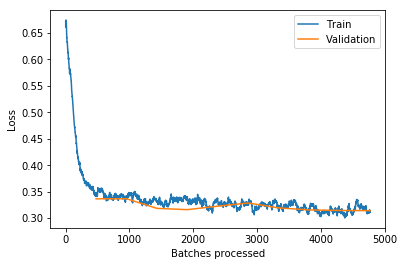

In [ ]:
learn.recorder.plot_losses()